# Electricity consumption using ARIMA

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import math

In [2]:
np.random.seed(7)

The dataset used is from  the Dublin City Council Civic Offices, Ireland.The time series ranges from 29th March 2011 to 17th February 2013.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP projects/Electriity_forcast/dccelectricitycivicsblocks34p20130221-1840.csv',
                engine='python', skipfooter=3 )
df.head()

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,...,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,02:00,02:15,02:30,02:45,03:00,03:15,03:30,03:45,04:00,04:15,04:30,04:45,05:00,05:15,05:30,05:45,06:00,06:15,06:30,06:45,07:00,07:15,07:30,07:45,08:00,08:15,08:30,08:45,09:00,09:15,...,14:00,14:15,14:30,14:45,15:00,15:15,15:30,15:45,16:00,16:15,16:30,16:45,17:00,17:15,17:30,17:45,18:00,18:15,18:30,18:45,19:00,19:15,19:30,19:45,20:00,20:15,20:30,20:45,21:00,21:15,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,57.30000305,52.95000076,48.29999924,47.40000153,44.55000305,40.20000076,40.20000076,40.5,40.95000076,38.55000305,39,36.75,37.65000153,34.95000076,34.95000076,33.90000153,30.30000114,31.80000305,32.70000076,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,31.5,30.00000191,32.85000229,27.45000076,27.90000153,27.90000153,32.10000229,31.5,28.79999924,33.15000153,32.40000153,32.40000153,34.05000305,41.55000305,38.25,47.40000153,49.95000458,60.30000305,58.80000305,62.25,61.35000229,66.59999847,68.40000153,66,71.25,71.70000458,72.45000458,74.70000458,73.05000305,69.75,...,71.8500061,73.05000305,72.15000153,70.65000153,70.80000305,73.65000153,75.90000916,68.25,69.15000153,66.30000305,60.45000458,52.79999924,57.90000153,54.45000458,53.55000305,53.85000229,47.85000229,47.70000076,45.60000229,47.85000229,46.20000076,48.15000153,46.20000076,40.80000305,35.70000076,34.20000076,34.05000305,34.05000305,34.20000076,33.75000381,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,34.65000153,35.25,36,33.60000229,35.70000076,33,30.75,31.35000229,33.30000305,33.15000153,33.45000076,38.25,37.65000153,41.40000153,46.05000305,47.85000229,46.95000076,59.40000153,63.15000153,63.75,69,67.20000458,69.45000458,72.15000153,69.90000153,73.65000153,70.94999695,79.19999695,74.40000153,71.8500061,...,74.25,73.20000458,72,73.5,72.75,73.3500061,75.6000061,76.20000458,72.90000153,75.15000153,62.55000305,60.45000458,57.75,50.40000153,53.85000229,50.70000458,47.85000229,47.10000229,47.85000229,45.30000305,43.80000305,43.80000305,42.15000153,42.60000229,42.45000458,42.30000305,40.5,38.70000076,39.30000305,36,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,33.15000153,32.70000076,33,30.15000153,33.00000381,31.20000076,34.20000076,32.40000153,34.20000076,31.95000076,29.40000153,36.60000229,34.05000305,38.10000229,39.45000076,44.25000381,44.85000229,52.80000305,55.8000030

# Data preprocessing

We can see that for each date, the relevant kilowatt consumption is provided across 15-minute intervals.
However, in this instance we wish to forecast the total daily consumption and there is expected to be too much volatility if the time series is formed on a 15-minute basis. 

In [4]:
df1 = df.rename(columns=df.iloc[0])
df2 = df1.drop(df1.index[0])


In [5]:
df3 = df2.drop(df2.index[0])

In [6]:
# Dropping null values
df4 = df3.dropna()

In [7]:
df5 = df4.set_index('Date')
df6 = df5.drop(columns=['Values'], axis=1)
# Converting into numpy array
df7 = df6.values
# Summimng up all values to get daily consumption
df8 = np.sum(df7, axis =1, dtype = 'float')
df8

array([4981.5001927 , 5166.60016445, 3046.35014537, 3101.10013769,
       4908.60016439, 4858.50017742, 4905.00019836, 4999.95019526,
       3075.90013122, 3023.5501442 , 5004.6001587 , 5199.30019957,
       5226.75017163, 5162.55022428, 4991.55017468, 2950.20010378,
       4883.85017776, 5055.15017129, 5084.10021592, 4914.00019451,
       3581.55014991, 2981.55008892, 2967.00011064, 3515.70014566,
       4721.10016438, 4931.85019494, 5020.05018234, 4799.40017322,
       3043.20012856, 2929.05012318, 3423.45014192, 4949.55017475,
       5155.05015188, 5238.75021174, 5129.10016059, 3088.95013995,
       3017.40010454, 5041.95018196, 5170.80017096, 5250.90023994,
       5239.35021975, 5163.60019308, 3169.65013694, 3034.65012932,
       5056.05021094, 5052.6001988 , 5048.2501869 , 4971.75019264,
       3013.20013239, 2919.45011703, 4830.0002022 , 5007.90018087,
       5028.00018885, 5088.60017207, 5092.35015869, 3069.90011787,
       2909.85011099, 4923.60022544, 5136.75021744, 5233.65021

In [8]:
df7.shape

(680, 96)

In [9]:
data  = pd.DataFrame(df8, columns=['Total_kilowatts'])
#data.to_csv("daily_kilowatt_consumption.csv")
data

,Total_kilowatts
0,4981.500193
1,5166.600164
2,3046.350145
3,3101.100138
4,4908.600164
...,...
675,4390.000000
676,4385.000000
677,4289.500000
678,2564.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


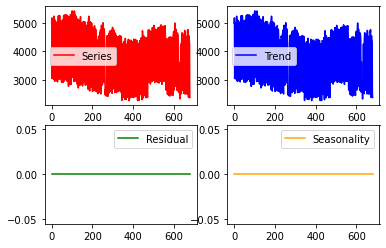

In [10]:
# Plotting the time series components
decomposition=seasonal_decompose(data, model='additive', freq=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

#Series
plt.subplot(221)
plt.plot(data,color='r', label='Series')
plt.legend(loc='best')
#Trend
plt.subplot(222)
plt.plot(trend,color='b', label='Trend')
plt.legend(loc='best')
#Residual
plt.subplot(223)
plt.plot(residual,color='g', label='Residual')
plt.legend(loc='best')
# Seasonality
plt.subplot(224)
plt.plot(seasonal,color='orange', label='Seasonality')
plt.legend(loc='best')

plt.show()

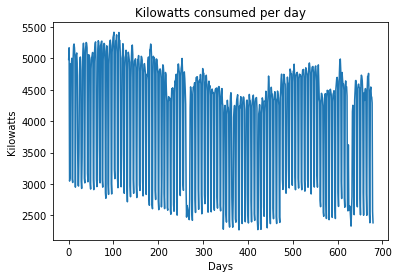

In [11]:
# plotting the data 
plt.plot(data)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title('Kilowatts consumed per day')
plt.show()

In [12]:
# Training data
train_data = df8[:550]
#Testing data
test_data = df8[550:]

In [13]:
train_data.shape, test_data.shape

((550,), (130,))

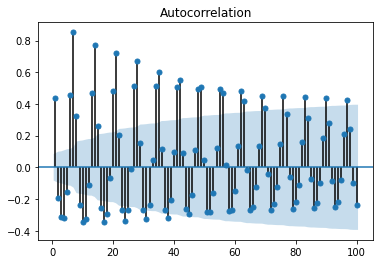

In [14]:
# Autocorrelation
plot_acf(train_data, lags=100, zero=False);

Highest positive correlation (after the negative correlations) is identified at lag 7. This indicates that there is a strong correlation with the kilowatt reading 7 days after the original.

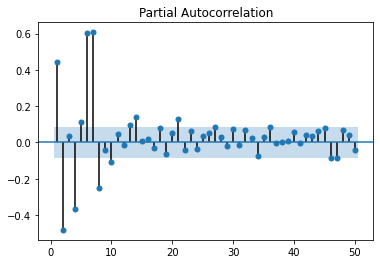

In [15]:
# Partial Autocorrelation
plot_pacf(train_data, lags=50, zero=False);

Before running the ARIMA model, let’s take a quick look at the 7-day moving average for this time series, in order to better visualise the overall trend.

In [16]:
window_size = 7

series = pd.Series(train_data)
window = series.rolling(window_size)
moving_avg = window.mean()

moving_avg_list = moving_avg.to_list()
ts7 = moving_avg_list[window_size - 1:]
ts7 = np.array(ts7)

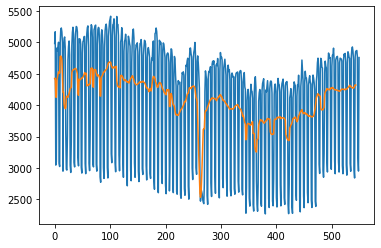

In [17]:
#n1 = math.nan
#n7 = np.array([n1,n1,n1,n1,n1,n1,n1])
#ts_7 = np.concatenate([n7, ts7])
# Plot for the trend
plt.plot(train_data)
plt.plot(ts7)
plt.show()

We can see that the overall kilowatt consumption seems to be decreasing in the first half of the series, while it increases across the second half.
Notably, we can see that there is quite a sharp drop halfway through the series, which clearly marks an anomaly in the series.
This might be due to a power cut or some other event that resulted in a sudden drop in electricity usage. When running the forecasts, we must bear in mind that this “time series shock” would not necessarily be accounted for by the past data.

# Dickey fuller test

In [37]:
# Dickey fuller test( Kind of hypothesis testing)
# H0 - the data is not stationary
# H1 - the data is stationary

def adfuller_test(value):
  result = ts.adfuller(value)
  labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'Number of observations used']
  for i, label in zip(result, labels):
    print(label+' : '+str(i))
  if result[1] <=0.05:
    print("Strong evidence against null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary")
  else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")

In [38]:
# Testing for data is stationarity
adfuller_test(train_data)

ADF Test Statistic : -2.926322377313574
p-value : 0.042371572372829694
#Lags used : 13
Number of observations used : 536
Strong evidence against null hypothesis(H0), reject the null hypothesis. Data has no unit root and is stationary


# Training
Using the training data, a stepwise search is now conducted using pmdarima to minimise the AIC value, i.e. select the ARIMA model that shows the lowest AIC.

In [21]:
Arima_model=pm.auto_arima(train_data, start_p=0, start_q=0, max_p=10, max_q=10,
                          start_P=0, start_Q=0, max_P=10, max_Q=10, m=7,
                          stepwise=True, seasonal=True, information_criterion='aic',
                          trace=True, d=1, D=1, error_action='warn', suppress_warnings= True,
                          random_state= 30, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8425.522, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8364.296, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=8262.235, Time=0.52 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=8302.760, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=1.87 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=8271.612, Time=0.40 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=8393.465, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=1.07 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=8357.890, Time=0.14 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=8264.235, Time=1.49 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]          
Total fit time: 

The most suitable ARIMA model is identified as ARIMA(0,1,1)(0,1,1)[7]

In [22]:
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  550
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -4128.117
Date:                           Mon, 27 Sep 2021   AIC                           8262.235
Time:                                   18:44:04   BIC                           8275.121
Sample:                                        0   HQIC                          8267.274
                                           - 550                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8249      0.014    -58.050      0.000      -0.853      -0.797
ma.S.L7       -0.3203      0.025    -12.770      0.000      -0.369      -0.271
sigma2      2.399e+05   6490.537     36.962      0.000    2.27e+05    2.53e+05
===================================================================================
Ljung-Box (L1) (Q):                  30.80   Jarque-Bera (JB):              1654.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Prediction 
Now predicting the daily consumption for 130 days

In [23]:
prediction = pd.DataFrame(Arima_model.predict(n_periods=130), index=test_data)

In [24]:
# convertiong into np array
prediction = np.array(prediction)
prediction.shape

(130, 1)

In [25]:
#prediction1=prediction.reshape(130,-1)
#prediction1.shape
# No. of days
len(prediction)

130

In [26]:
mse =mean_squared_error(test_data, prediction)
rmse = math.sqrt(mse)
print(f"The RMSE is: {rmse}")

The RMSE is: 1449.9061171255178


In [27]:
np.mean(test_data)

3890.892307692308

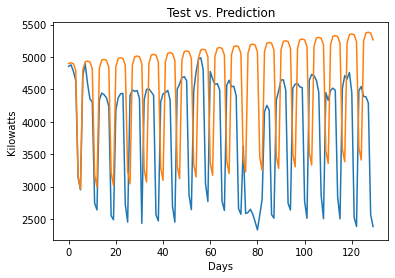

In [28]:
# Plotting the test data wrt prediction
plt.plot(test_data)
plt.plot(prediction)
plt.xlabel('Days')
plt.ylabel('Kilowatts')
plt.title("Test vs. Prediction")
plt.show()

We can see that the ARIMA model has picked up the seasonal trend of the series quite well. That said, the peak consumption predictions in the first half of the graph appear to be quite a bit higher than the actual.
Moreover, we see that the model fails to capture the drop in kilowatt consumption between roughly days 70–80 across the test set. This anomaly may be contributing to the sizeable error we are seeing for the RMSE value, as RMSE is designed to penalise errors on outliers more heavily.